In [1]:
# # Install some packages
# %pip install rasterio
# %pip install earthpy

In [2]:
# Import packages
# import tensorflow_decision_forests as tfdf
import pandas as pd                                                                                 # For loading the data into a DataFrame
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report         # For evaluating the model
import matplotlib.pyplot as plt                                                                     # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data

2024-11-27 08:06:07.400256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732669567.411980  199099 cuda_dnn.cc:8498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732669567.415339  199099 cuda_blas.cc:1410] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 08:06:07.429098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Parameter
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
CLASSES = [1, 2, 3, 4, 5, 6]
LABEL = ['classvalue']
SPLIT = ['sample']
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
PALETTE = ['#8B0100', '#B86401', '#008080', '#87CEFA', '#65A300', '#006401']
SAMPLE_PATH = 'ndvi_data/Samples_LC_Jambi_2023_ALLFEATURES.csv'
IMAGE_PATH = 'ndvi_data/Landsat_Jambi_2023_6CLASSESNDVI.tif'

/home/seviko/python/tf217/lib/python3.12/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


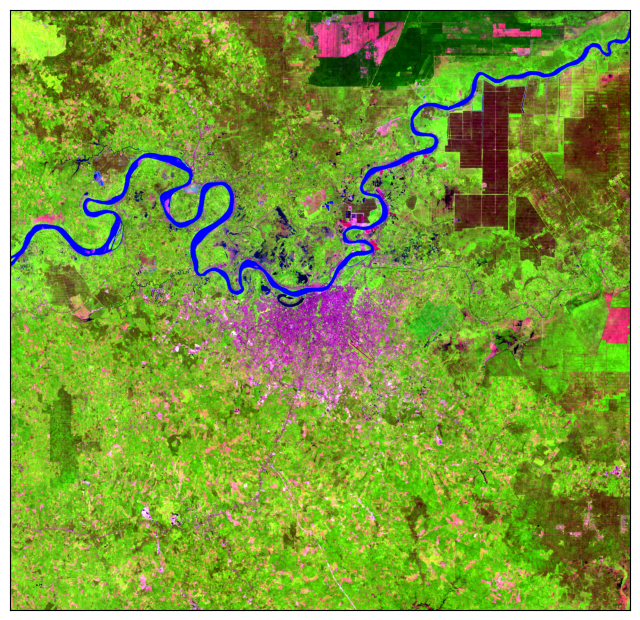

<Axes: >

In [4]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [5]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

B1        B2        B3        B4        B5        B6        B7  \
26318  0.007707  0.012547  0.030422  0.025087  0.246435  0.111658  0.051020   
16971  0.032485  0.038012  0.058390  0.045217  0.225672  0.164787  0.073983   
17090  0.030752  0.036170  0.058692  0.038865  0.210547  0.162093  0.069197   
8952   0.033599  0.038879  0.069871  0.061264  0.236095  0.223789  0.125834   
8038   0.025362  0.025995  0.051048  0.033035  0.160718  0.103820  0.065870   
...         ...       ...       ...       ...       ...       ...       ...   
15549  0.062460  0.079757  0.151587  0.184972  0.133685  0.043485  0.031165   
27171  0.003335  0.007391  0.019491  0.013414  0.146940  0.064302  0.027769   
2326   0.063478  0.075742  0.104645  0.122327  0.156620  0.195065  0.185138   
7166   0.061497  0.080280  0.201033  0.290133  0.390356  0.506406  0.283753   
316    0.058885  0.071274  0.108880  0.121392  0.235366  0.279504  0.229715   

            EVI       NBR      NDMI      NDWI      NDBI     NDBaI      NDVI  \
26318  0.424736  0.656957  0.376376 -0.780230 -0.376376  0.372747  0.815209   
16971  0.372261  0.506215  0.155931 -0.588893 -0.155931  0.380303  0.666156   
17090  0.366072  0.505282  0.130032 -0.564014 -0.130032  0.401639  0.688348   
8952   0.333117  0.304649  0.026759 -0.543275 -0.026759  0.280174  0.587947   
8038   0.274240  0.418591  0.215083 -0.517885 -0.215083  0.223643  0.658998   
...         ...       ...       ...       ...       ...       ...       ...   
15549 -0.077928  0.621899  0.509116  0.062756 -0.509116  0.165037 -0.160949   
27171  0.284829  0.682114  0.391197 -0.765774 -0.391197  0.396799  0.832698   
2326   0.064824 -0.083444 -0.109317 -0.198936  0.109317  0.026111  0.122935   
7166   0.099072  0.158140 -0.129410 -0.320134  0.129410  0.281784  0.147282   
316    0.199371  0.012151 -0.085726 -0.367430  0.085726  0.097775  0.319470   

       elevation  classvalue sample  
26318       1742           6  train  
16971         10           5  train  
17090         12           5  train  
8952           6           3  train  
8038           9           3  train  
...          ...         ...    ...  
15549          7           4   test  
27171       1917           6  train  
2326         717           1  train  
7166          44           2  train  
316           39           1  train  

[28644 rows x 17 columns]

In [ ]:
# from ydata_profiling import ProfileReport
# ProfileReport(samples[FEATURES], title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = tf.keras.utils.to_categorical(train_label.to_numpy())
test_output = tf.keras.utils.to_categorical(test_label.to_numpy())

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (23814, 9, 1)
Test features: (4830, 9, 1)
Train label: (23814, 7)
Test label: (4830, 7)


In [8]:
filtered_train = train[FEATURES + LABEL]
Label1 = filtered_train[filtered_train['classvalue'] == 1]
Label2 = filtered_train[filtered_train['classvalue'] == 2]
Label3 = filtered_train[filtered_train['classvalue'] == 3]
Label4 = filtered_train[filtered_train['classvalue'] == 4]
Label5 = filtered_train[filtered_train['classvalue'] == 5]
Label6 = filtered_train[filtered_train['classvalue'] == 6]

print("Label 1", Label1["classvalue"].count())
print("Label 2", Label2["classvalue"].count())
print("Label 3", Label3["classvalue"].count())
print("Label 4", Label4["classvalue"].count())
print("Label 5", Label5["classvalue"].count())
print("Label 6", Label6["classvalue"].count())

Label 1 4967
Label 2 1567
Label 3 4019
Label 4 2900
Label 5 3262
Label 6 7099


In [9]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.4
kernel = 2
pool = 2

# Make sequential model
model = tf.keras.Sequential([
  tf.keras.Input(input_shape),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 2, kernel, activation='relu'),
  tf.keras.layers.AveragePooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  tf.keras.layers.Conv1D(neuron * 1, kernel, activation='relu'),
  # MaxPooling1D(pool),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.GlobalAveragePooling1D(),
  
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(neuron * 2, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(neuron * 1, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)),
  tf.keras.layers.Dropout(drop),
  tf.keras.layers.Dense(NUM_CLASSES + 1, activation='softmax')
])

model.summary()

I0000 00:00:1732669588.227492  199099 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5660 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:10:00.0                                                   , compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 128)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 3, 128)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,271 (294.03 KB)

 Trainable params: 75,143 (293.53 KB)

 Non-trainable params: 128 (512.00 B)

In [10]:
# Train the model
from sklearn.utils.class_weight import compute_class_weight

train_output_flat = np.argmax(train_output, axis=1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_output_flat), y=train_output_flat)
class_weights = dict(enumerate(class_weights))

print(class_weights)

# Compline the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.5,
    min_lr=1e-6
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop, lr_callback],  
    epochs=500,
    class_weight=class_weights
)

{0: np.float64(0.7990738876585464), 1: np.float64(2.532865347798341), 2: np.float64(0.9875590943020652), 3: np.float64(1.3686206896551725), 4: np.float64(1.2167381974248928), 5: np.float64(0.5590928299760529)}
AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
Epoch 1/500


I0000 00:00:1732669590.811051  199320 service.cc:152] XLA service 0x7f9128003630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732669590.811090  199320 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-11-27 08:06:30.857600: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732669591.087984  199320 cuda_dnn.cc:529] Loaded cuDNN version 90300


22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1020 - loss: 11.3100

2024-11-27 08:06:34.960817: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 84 bytes spill stores, 76 bytes spill loads

I0000 00:00:1732669594.981287  199320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 379ms/step - accuracy: 0.1028 - loss: 11.2950 - val_accuracy: 0.1805 - val_loss: 10.2698 - learning_rate: 1.0000e-04
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1606 - loss: 10.8639 - val_accuracy: 0.1805 - val_loss: 9.9346 - learning_rate: 1.0000e-04
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2276 - loss: 10.4760 - val_accuracy: 0.1805 - val_loss: 9.6136 - learning_rate: 1.0000e-04
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2735 - loss: 10.0615 - val_accuracy: 0.3934 - val_loss: 9.3097 - learning_rate: 1.0000e-04
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3362 - loss: 9.5837 - val_accuracy: 0.4689 - val_loss: 9.0222 - learning_rate: 1.0000e-04
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3949 - loss: 9.0659 - val_accuracy: 0.4712 - val_loss: 8.7393 - learning_rate: 1.0000e-04
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4484 - lo

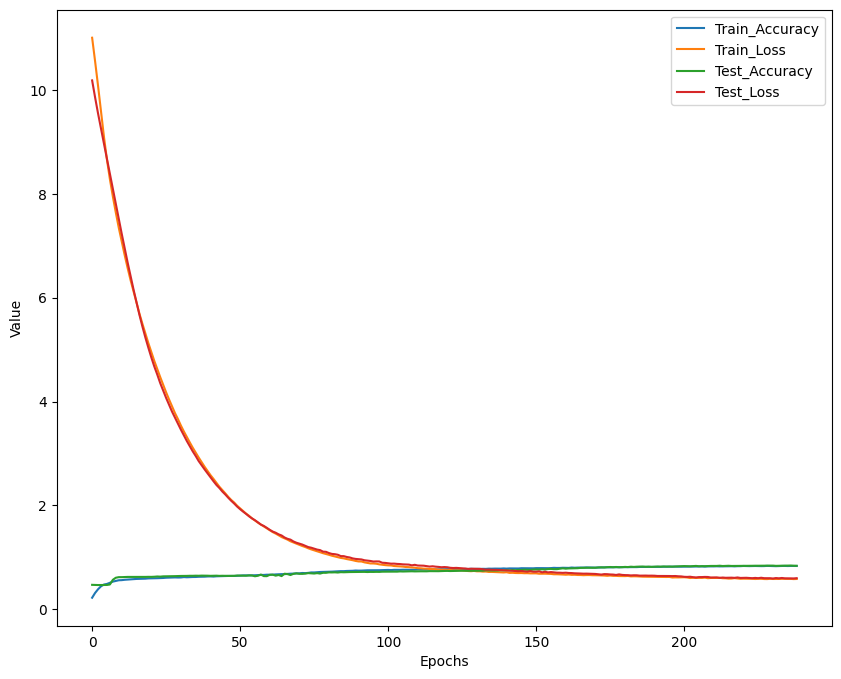

In [ ]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           1       0.95      0.99      0.97       872
           2       0.72      0.90      0.80       307
           3       0.77      0.76      0.76       710
           4       0.99      0.98      0.98       531
           5       0.94      0.54      0.69       967
           6       0.76      0.93      0.83      1443

    accuracy                           0.84      4830
   macro avg       0.85      0.85      0.84      4830
weighted avg       0.85      0.84      0.83      4830



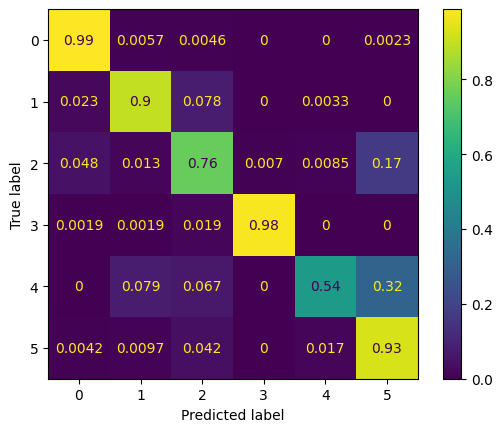

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

# Classification report
print(classification_report(label, prediction))

45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step


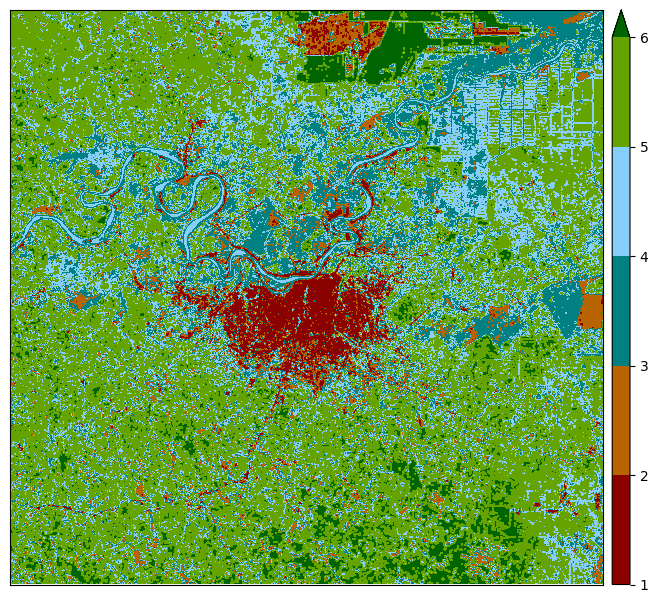

<Axes: >

In [ ]:
# Predict image using the model
image_input = []
for x in range(NUM_OF_BANDS):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)